# Import Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

## Get the Data

**read Train.csv as a dataframe called train_reviews**

In [3]:
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

**Check out the info(), head(), and describe() methods on train_reviews**

In [4]:
train_descr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Text_ID              6364 non-null   int64 
 1   Product_Description  6364 non-null   object
 2   Product_Type         6364 non-null   int64 
 3   Sentiment            6364 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 199.0+ KB


In [5]:
train_descr.head()

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [6]:
train_descr.describe()

,Text_ID,Product_Type,Sentiment
count,6364.000000,6364.000000,6364.000000
mean,4568.862822,7.462445,2.230673
std,2621.198346,2.440492,0.638413
min,1.000000,0.000000,0.000000
25%,2297.750000,6.000000,2.000000
50%,4587.500000,9.000000,2.000000
75%,6827.500000,9.000000,3.000000
max,9092.000000,9.000000,3.000000


# Exploratory Data Analysis

### Non-text data

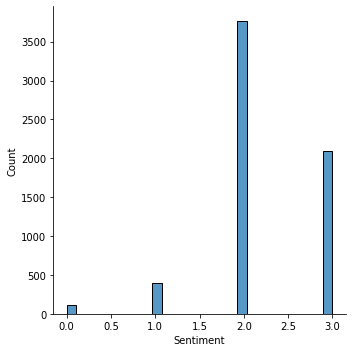

In [7]:
sns.displot(train_descr, x="Sentiment")

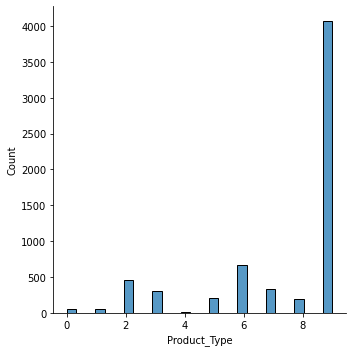

In [8]:
sns.displot(train_descr, x="Product_Type")

### Text Data

In [9]:
sentiment_descr_list = train_descr.loc[:, [
    'Sentiment', 'Product_Description']].values.tolist()

In [10]:
len(sentiment_descr_list)

6364

In [11]:
sentiment_descr_array = np.array(sentiment_descr_list)
sentiment_descr_array

array([['2',
        'The Web Designer\x89Ûªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw'],
       ['2',
        'RT @mention Line for iPad 2 is longer today than yesterday. #SXSW  // are you getting in line again today just for fun?'],
       ['2',
        'Crazy that Apple is opening a temporary store in Austin tomorrow to handle the rabid #sxsw eye pad too seekers.'],
       ...,
       ['2',
        'RT @mention RT @mention Download 20+ free tracks from @mention Music Sampler @mention including @glove! {link} #SXSW'],
       ['2',
        "OH at Texas Social Media Awards: 'You don't need to ask your mother anymore. Just Google it.' #sxswi #sxsw"],
       ['2',
        '#Google launching a &quot;major&quot; new social network at #sxsw ... Wonder what that can be...']],
      dtype='<U178')

#### Take a look at the lengths of the different descriptions

In [12]:
for index, descr in enumerate(sentiment_descr_array[:16]):
    print("Index: {} Length: {}".format(index, len(descr[1])))

Index: 0 Length: 89
Index: 1 Length: 119
Index: 2 Length: 111
Index: 3 Length: 137
Index: 4 Length: 87
Index: 5 Length: 137
Index: 6 Length: 112
Index: 7 Length: 115
Index: 8 Length: 90
Index: 9 Length: 110
Index: 10 Length: 96
Index: 11 Length: 121
Index: 12 Length: 99
Index: 13 Length: 134
Index: 14 Length: 125
Index: 15 Length: 104


In [13]:
type(sentiment_descr_array)

numpy.ndarray

min 11
mean 104.64346323067254
std 27.28305668307883
max 178


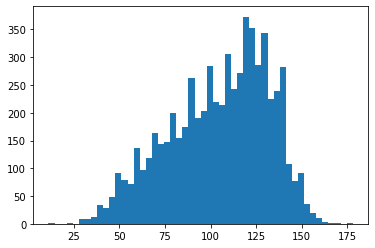

In [53]:
lengths = [len(x[1]) for x in sentiment_descr_array]
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("std", np.std(lengths))
print("max", np.max(lengths))
plt.hist(lengths, bins=50)
plt.show()
plt.close()

### Things to think about: 
* make the path flexible
* further data exploration
* unbalanced data by both Product_Type and Sentiment - down- / up sample? 
* different ways of encoding Product_Type